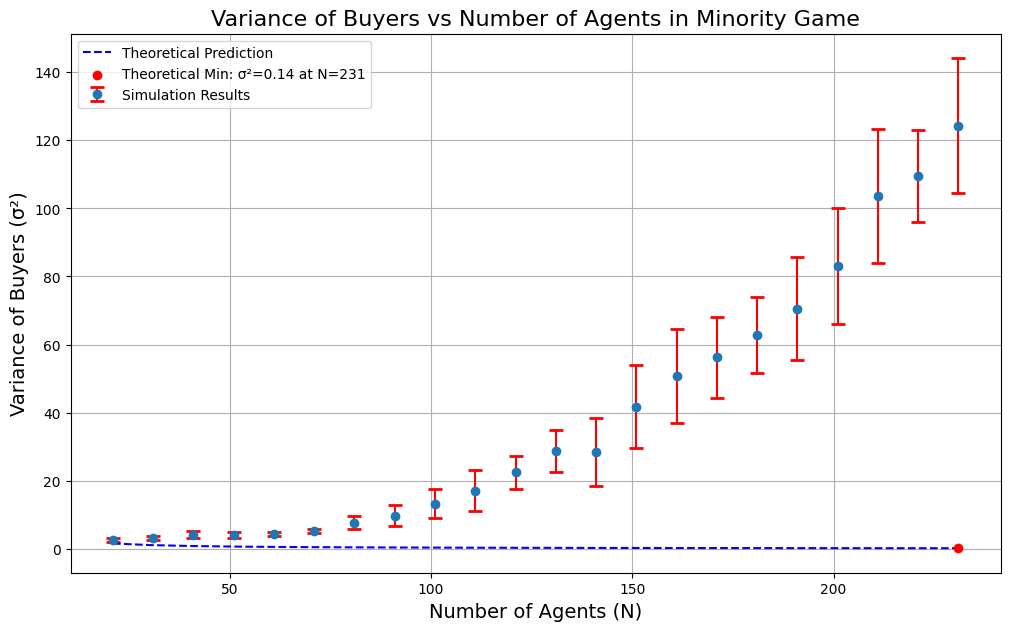

In [5]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

class Strategy:
    def __init__(self, m):
        self.m = m
        self.num_states = 2 ** m
        self.action_map = {state: random.choice([1, -1]) for state in range(self.num_states)}

    def predict(self, state):
        return self.action_map[state]

class Agent:
    def __init__(self, m, s):
        self.strategies = [Strategy(m) for _ in range(s)]
        self.real_score = 0

    def choose_strategy(self, virtual_scores):
        max_score = max(virtual_scores)
        best_strategies = [i for i, score in enumerate(virtual_scores) if score == max_score]
        return self.strategies[random.choice(best_strategies)]

def run_simulation(m, s, N, T, T0):
    agents = [Agent(m, s) for _ in range(N)]
    virtual_scores = [[0.0] * s for _ in agents]
    current_state = 0
    history = [0] * m
    buyers_record = []

    for t in range(T):
        actions = []
        for agent, scores in zip(agents, virtual_scores):
            strategy = agent.choose_strategy(scores)
            actions.append(strategy.predict(current_state))

        # Calculate excess demand
        A = sum(actions)

        # Determine minority action
        if A > 0:
            minority_action = -1
        elif A < 0:
            minority_action = 1
        else:
            minority_action = random.choice([1, -1])

        # Update virtual scores based on minority action
        for scores, agent in zip(virtual_scores, agents):
            for j, strategy in enumerate(agent.strategies):
                prediction = strategy.predict(current_state)
                scores[j] += minority_action * prediction / N

        # Update historical state
        history.append(minority_action)
        if len(history) > m:
            history.pop(0)
        current_state = int("".join(['1' if x > 0 else '0' for x in history]), 2)

        # Record buyers after steady state
        if t >= T0:
            buyers_record.append((A + N) / 2)

    return buyers_record

def main():
    m = 5
    s = 2
    T = 1000
    T0 = 200
    num_samples = 10
    N_values = np.arange(21, 232, 10)

    average_variances = []
    std_variances = []

    for N in N_values:
        variances = []
        for _ in range(num_samples):
            buyers = run_simulation(m, s, N, T, T0)
            variances.append(np.var(buyers))
        average_variances.append(np.mean(variances))
        std_variances.append(np.std(variances))

    theoretical_variance = [2 ** m / N for N in N_values]

    plt.figure(figsize=(12, 7))
    plt.errorbar(N_values, average_variances, yerr=std_variances, fmt='o', ecolor='r', capthick=2, capsize=5, label='Simulation Results')
    plt.plot(N_values, theoretical_variance, linestyle='--', color='b', label='Theoretical Prediction')
    min_index = np.argmin(theoretical_variance)
    min_n = N_values[min_index]
    min_theoretical = theoretical_variance[min_index]
    plt.scatter([min_n], [min_theoretical], color='red', zorder=5, label=f"Theoretical Min: σ²={min_theoretical:.2f} at N={min_n}")
    plt.xlabel('Number of Agents (N)', fontsize=14)
    plt.ylabel('Variance of Buyers (σ²)', fontsize=14)
    plt.title('Variance of Buyers vs Number of Agents in Minority Game', fontsize=16)
    plt.grid(True)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()

In [8]:
import numpy as np
import matplotlib.pyplot as plt


class MinorityGame:
    def __init__(self, m=5, s=2, iter=1000, iteq=200):
        self.m = m
        self.s = s
        self.iter = iter
        self.iteq = iteq

    def simulate_once(self, N):
        agents = [Agent(self.m, self.s) for _ in range(N)]
        state = 0
        buyers_count = []

        for t in range(self.iter):
            actions = []
            chosen_strategies = []
            for agent in agents:
                action, strategy_idx = agent.choose_action(state)
                actions.append(action)
                chosen_strategies.append(strategy_idx)
            
            actions = np.array(actions)
            buyers = np.sum(actions == 1)
            excess_demand = 2 * buyers - N

            for i, agent in enumerate(agents):
                for j in range(self.s):
                    prediction = agent.strategies[j].predict(state)
                    agent.virtual_scores[j] += -prediction * excess_demand / N
                
                agent.real_score += -actions[i] * excess_demand / N

            state = (((state << 1) & ((2**self.m)-1)) | (1 if excess_demand > 0 else 0))

            if t >= self.iteq:
                buyers_count.append(buyers)

        variance = np.var(buyers_count)
        return variance, buyers_count[-1], np.mean(buyers_count)

    def run_simulation(self):
        N_values = np.linspace(21, 231, 15).astype(int)
        nsam = 10  

        results = []
        errors = []
        x_values = []

        print("\n=== Simulation Results ===")
        print("Format: N | 2^m/N | σ²/N (mean ± std) | Avg Buyers | Last Buyers")
        print("-" * 70)

        for N in N_values:
            variances = []
            avg_buyers_list = []
            last_buyers_list = []
            
            for sample in range(nsam):
                variance, last_buyers, avg_buyers = self.simulate_once(N)
                variances.append(variance/N)
                avg_buyers_list.append(avg_buyers)
                last_buyers_list.append(last_buyers)
            
            mean_variance = np.mean(variances)
            std_variance = np.std(variances)/np.sqrt(nsam)
            mean_avg_buyers = np.mean(avg_buyers_list)
            mean_last_buyers = np.mean(last_buyers_list)
            
            results.append(mean_variance)
            errors.append(std_variance)
            x_value = 2**self.m/N
            x_values.append(x_value)

            print(f"N={N:3d} | {x_value:.3f} | {mean_variance:.3f} ± {std_variance:.3f} | "
                  f"{mean_avg_buyers:.1f} | {mean_last_buyers:.1f}")

        print("\nTheoretical optimal 2^m/N ratio: 0.34")
        min_index = np.argmin(results)
        print(f"Observed optimal 2^m/N ratio: {x_values[min_index]:.3f}")
        print(f"Minimum scaled variance: {results[min_index]:.3f} ± {errors[min_index]:.3f}")

        self.plot_results(x_values, results, errors)
        return x_values, results, errors

    def plot_results(self, x_values, results, errors):
        plt.figure(figsize=(10, 6))
        plt.errorbar(x_values, results, yerr=errors, fmt='o-', capsize=5)
        plt.xlabel('2^m/N')
        plt.ylabel('σ²/N')
        plt.title('Scaled variance vs 2^m/N')
        plt.grid(True)

        plt.axvline(x=0.34, color='r', linestyle='--', 
                   label='Theoretical minimum (2^m/N ≈ 0.34)')
        
        min_index = np.argmin(results)
        min_x = x_values[min_index]
        plt.axvline(x=min_x, color='g', linestyle='--', 
                   label=f'Observed minimum (2^m/N ≈ {min_x:.3f})')
        
        plt.legend()
        plt.show()

def main():
    np.random.seed(42)
    print("Starting Minority Game Simulation...")
    print(f"Parameters: m=5, s=2, iterations=1000, equilibrium period=200")
    
    game = MinorityGame(m=5, s=2, iter=1000, iteq=200)
    game.run_simulation()

if __name__ == "__main__":
    main()

Starting Minority Game Simulation...
Parameters: m=5, s=2, iterations=1000, equilibrium period=200

=== Simulation Results ===
Format: N | 2^m/N | σ²/N (mean ± std) | Avg Buyers | Last Buyers
----------------------------------------------------------------------


TypeError: cannot unpack non-iterable numpy.int64 object